In [776]:
from geopy.distance import geodesic
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from tqdm import tqdm 
from geopy.geocoders import Nominatim

import os 
from glob import glob
import warnings
warnings.filterwarnings('ignore')

In [777]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

In [778]:
train_path = '../fill_loc_train.csv'
test_path  = '../fill_loc_test.csv'
bus_feature_path = '../bus_feature.csv'
subway_feature_path = '../subway_feature.csv'

df_train = pd.read_csv(train_path)
df_bus = pd.read_csv(bus_feature_path)
df_subway = pd.read_csv(subway_feature_path)
df_test = pd.read_csv(test_path)

df_train.rename({'k-전체세대수' : '세대수(세대)', '건축면적' : '건축면적(㎡)', 'k-연면적' : '연면적(㎡)'}, axis=1, inplace=True)
df_bus = df_bus.rename({'Y좌표' : '좌표Y', 'X좌표' : '좌표X'}, axis=1)
df_subway = df_subway.rename({'위도' : '좌표Y', '경도' : '좌표X'}, axis=1)

In [779]:
# 시군으로 나누기
df_train['시군'] = df_train['시군구'].str.split().str[:2].apply(lambda x: ' '.join(x))

# 도로명 데이터를 이용하여 도로명주소 생성
df_train['주소'] = df_train['시군구'] + ' ' + df_train['번지']
df_train['도로명주소'] = df_train['시군'] + ' ' + df_train['도로명']

# 번지 주소가 없다면 도로명 주소로 채워줌, 번지 주소는 loc을 위함 
df_train.loc[df_train['주소'].isna(), '주소'] = df_train.loc[df_train['주소'].isna(), '시군'] + ' ' + df_train.loc[df_train['주소'].isna(), '도로명']

# 도로명의 값이 ' '인 값들을 찾아서 넣어줌
df_train.loc[(df_train['도로명'] == ' ') & (df_train['주소'] == '서울특별시 성동구 하왕십리동 1071'), '도로명주소'] = '서울특별시 성동구 난계로 100'
df_train.loc[(df_train['도로명'] == ' ') & (df_train['주소'] == '서울특별시 중구 만리동2가 288'), '도로명주소'] = '서울특별시 중구 만리재로 177'
df_train.loc[(df_train['도로명'] == ' ') & (df_train['주소'] == '서울특별시 성북구 돈암동 13-85'), '도로명주소'] = '서울특별시 성북구 돈암동 동소문로34길 73'
df_train.loc[(df_train['도로명'] == ' ') & (df_train['주소'] == '서울특별시 마포구 아현동 372-29'), '도로명주소'] = '서울특별시 마포구 마포대로24길 16'
df_train.loc[(df_train['도로명'] == ' ') & (df_train['주소'] == '서울특별시 송파구 송파동 167'), '도로명주소'] = ' 서울특별시 송파구 오금로32길 31'
df_train.loc[(df_train['도로명'] == ' ') & (df_train['주소'] == '서울특별시 송파구 거여동 696'), '도로명주소'] = '서울특별시 송파구 오금로 551'
df_train.loc[(df_train['도로명'] == ' ') & (df_train['주소'] == '서울특별시 강남구 역삼동 762'), '도로명주소'] = '서울특별시 강남구 도곡로43길 21'
df_train.loc[(df_train['도로명'] == ' ') & (df_train['주소'] == '서울특별시 서초구 반포동 30-2'), '도로명주소'] = '서울특별시 서초구 고무래로 35'
df_train.loc[(df_train['도로명'] == ' ') & (df_train['주소'] == '서울특별시 종로구 옥인동 179-3'), '도로명주소'] = '서울 종로구 옥인길 82'
df_train.loc[(df_train['도로명'] == ' ') & (df_train['주소'] == '서울특별시 강남구 역삼동 763'), '도로명주소'] = '서울 강남구 도곡로43길 20'
df_train.loc[(df_train['도로명'] == ' ') & (df_train['주소'] == '서울특별시 서초구 서초동 1686-4'), '도로명주소'] = '서울 서초구 서초중앙로24길 33'

# 같은 주소이지만 도로명 값이 없는경우 다른 도로명주소가 생겨서 같은 도로명주소로 채워줌 
df_train['도로명주소'] = df_train.groupby('주소')['도로명주소'].transform('first')
df_train['주소'].isna().sum()

0

In [780]:
# display(df_train[df_train['주소'] == '서울특별시 용산구 한강로2가 196']) # 1113986
# display(df_train[df_train['주소'] == '서울특별시 마포구 토정동 2-4']) # 1050833

In [781]:
# 데이터의 개수가 1개이고 없는 정보가 많아 삭제
# df_train.drop([1050833, 1113986], inplace=True)

## 건설사 결측치 채우기

In [782]:
df_apt = pd.read_csv('../seoul_apt_info.csv', encoding='cp949')
df_apt.rename({'kapt도로명주소' : '도로명주소'}, axis=1, inplace=True)

In [783]:
df_construction = df_train[['도로명주소', 'k-건설사(시공사)']].drop_duplicates()
df_construction = df_construction.merge(df_apt[['도로명주소', 'k-건설사(시공사)']], how='left', on='도로명주소', suffixes=('_1', '_2'))
df_construction['k-건설사(시공사)_2'] = df_construction['k-건설사(시공사)_2'].fillna(df_construction['k-건설사(시공사)_1'])
df_construction = df_construction[['도로명주소', 'k-건설사(시공사)_2']].rename({'k-건설사(시공사)_2' : 'k-건설사(시공사)'}, axis=1)
mapping_constructions = df_construction[df_construction['k-건설사(시공사)'].notnull()].to_dict(orient='records')

In [784]:
print('처리전 : ', df_train['k-건설사(시공사)'].isna().sum())
for construction in tqdm(mapping_constructions):
    df_train.loc[df_train['도로명주소'] == construction['도로명주소'], 'k-건설사(시공사)'] = construction['k-건설사(시공사)']
print('처리후 : ', df_train['k-건설사(시공사)'].isna().sum())

처리전 :  871056


100%|██████████| 2362/2362 [02:04<00:00, 19.03it/s]

처리후 :  256919


In [785]:
constructions = ['삼성', '신한', '주택공사', '에스케이|SK', '극동', '코오롱', '한솔', '대명', '한성', '건영', '유원', '한신공영', '갑을', 
                '한보', '태영', '청구', '중앙', '삼호', '삼환', '현대', '순영', '효성', '에스에이치|SH|sh', '대성', '서희', 'DL|디엘',
                '두산', '울트라', '동원', '한화', '벽산', '제일', '삼부', '흥화', '신도', '우남', '자이', '남광', '금강', '라온', '우방',
                '롯데', '호반', '우림', '동양', '한진', '삼천리', '서광', 'LIG', '진도', '한일', '동성', '포스코', '우성', '한라', '동부',
                '영풍', 'KCC|kcc', '진로', '성원', '세방', '동일', '진흥', '우리', '대주', '라이프', '선경', '라인', '지에스|GS|gs', '신동아',
                '고려', '금호', '삼익', '신창', '신일', '세양', '동아', '동광', '신안', '풍림', '대우', '쌍용', '신성', '상계', '양우', '계룡',
                '일성', '대림', '월드', '미주', '우정', '삼정', 'LG|엘지', '자유', '한양', '경남', '성지']

In [786]:
df_train['k-건설사(시공사)'] = df_train['k-건설사(시공사)'].fillna('unknown')
df_train['아파트명'] = df_train['아파트명'].fillna('unknown')
for construction in tqdm(constructions):
    df_train.loc[df_train['아파트명'].str.contains(construction), 'k-건설사(시공사)'] = construction

df_train.loc[df_train['k-건설사(시공사)'] == '아크로리버뷰신반포', 'k-건설사(시공사)'] = '대림'

100%|██████████| 97/97 [00:25<00:00,  3.75it/s]


## 데이터 병합

In [787]:
df_apt_info = pd.read_csv('../apt_info.csv')
df_info = df_apt_info[['도로명주소', '세대수(세대)', '건축면적(㎡)', '연면적(㎡)']]
df_info = df_info.groupby(['도로명주소']).mean().reset_index()
df_train = df_train.merge(df_info, how='left', on=['도로명주소'], suffixes=('_1', '_2'))
df_train['세대수(세대)_1'].fillna(df_train['세대수(세대)_2'], inplace=True)
df_train['건축면적(㎡)_1'].fillna(df_train['건축면적(㎡)_2'], inplace=True)
df_train['연면적(㎡)_1'].fillna(df_train['연면적(㎡)_2'], inplace=True)
df_train.drop(columns=['세대수(세대)_2', '건축면적(㎡)_2', '연면적(㎡)_2'], inplace=True)
df_train.rename({"세대수(세대)_1" : "세대수(세대)", "건축면적(㎡)_1" : "건축면적(㎡)", "연면적(㎡)_1" : "연면적(㎡)"}, axis=1, inplace=True)

In [788]:
parkinglot = df_apt.groupby('도로명주소')['주차대수'].mean().reset_index()
df_train = df_train.merge(parkinglot, how='left', on='도로명주소', suffixes=('_1', '_2'))
df_train['주차대수_1'] = df_train['주차대수_1'].fillna(df_train['주차대수_2'])
df_train = df_train.drop(columns=['주차대수_2'], axis=1).rename({'주차대수_1' : '주차대수'}, axis=1)

df_train.rename({'k-전체세대수' : '세대수(세대)', '건축면적' : '건축면적(㎡)', 'k-연면적' : '연면적(㎡)'}, axis=1, inplace=True)

In [789]:
base_interest_rate = pd.read_excel('../base_interest_rate.xlsx', names=['날짜', '기준금리', 'RP금리(익일물)'])
base_interest_rate['날짜'] = base_interest_rate['날짜'].str.replace('-', '')

df_train['계약년월'] = df_train['계약년월'].astype(str)
df_train['계약일'] = df_train['계약일'].astype(str)
df_train['계약일'] = df_train['계약일'].apply(lambda x: '0' + x if len(x) == 1 else x)
df_train['날짜'] = df_train['계약년월'] + df_train['계약일'] 

df_train = df_train.merge(base_interest_rate[['날짜', '기준금리']], how='left', on='날짜')

In [790]:
df_train['기준금리'] = df_train['기준금리'].fillna(1.5)

In [791]:
bus_count_train_df = pd.read_csv('../bus_count_train.csv')
subway_count_train_df = pd.read_csv('../subway_count_train.csv')
school_count_train_df = pd.read_csv('../school_count_train.csv')
hospital_count_train_df = pd.read_csv('../hospital_count_train.csv')
park_count_train_df = pd.read_csv('../park_count_train.csv')

In [792]:
df_train = pd.concat([df_train, bus_count_train_df, subway_count_train_df, school_count_train_df, hospital_count_train_df, park_count_train_df], axis=1)

## 파생변수 생성

In [793]:
df_train['구'] = df_train['시군구'].str.split().str[1]
df_train['동'] = df_train['시군구'].str.split().str[2]

In [794]:
df_train['구'] = df_train['시군구'].str.split().str[1]
df_train['동'] = df_train['시군구'].str.split().str[2]

near_river = ['서울특별시 영등포구 여의동', '서울특별시 용산구 이촌동', '서울특별시 강남구 신사동', '서울특별시 서초구 잠원동', '서울특별시 강남구 압구정동', '서울특별시 강남구 청담동', '서울특별시 송파구 신천동', '서울특별시 송파구 잠실동', '서울특별시 용산구 한남동', '서울특별시 서초구 반포동']
df_train['한강근처여부'] = df_train['시군구'].apply(lambda x: 1 if x in near_river else 0)

df_train['계약년'] = df_train['계약년월'].astype('str').map(lambda x : x[:4])
df_train['계약월'] = df_train['계약년월'].astype('str').map(lambda x : x[4:])

region_premium = ['서울특별시 강남구', '서울특별시 서초구', '서울특별시 용산구', '서울특별시 송파구']
df_train['지역프리미엄'] = df_train['시군'].apply(lambda x: 1 if x in region_premium else 0)

district = list(df_train['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in district if x not in gangnam]

# 강남의 여부를 체크합니다.
is_gangnam = []
for x in df_train['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
df_train['강남여부'] = is_gangnam

# 신축, 준신축, 구축 구분 
def buliding_condition(data):
    if data <= 5: # 신축
        return 0
    elif 5 < data <= 10: # 준신축
        return 1
    else: # 구축
        return 2
df_train['연식'] = df_train['계약년'].astype(int) - df_train['건축년도']
df_train['건물상태'] = df_train['연식'].apply(buliding_condition)

# 재건축 가능 
df_train['재건축가능'] = 0
df_train.loc[(df_train['연식'] >= 20) & (df_train['건축년도'] <= 1981), '재건축가능'] = 1
df_train.loc[(df_train['연식'] >= 22) & (df_train['건축년도'] <= 1982), '재건축가능'] = 1
df_train.loc[(df_train['연식'] >= 24) & (df_train['건축년도'] <= 1983), '재건축가능'] = 1
df_train.loc[(df_train['연식'] >= 26) & (df_train['건축년도'] <= 1984), '재건축가능'] = 1
df_train.loc[(df_train['연식'] >= 28) & (df_train['건축년도'] <= 1985), '재건축가능'] = 1
df_train.loc[(df_train['연식'] >= 30) & (df_train['건축년도'] <= 1986), '재건축가능'] = 1

top10 = ['자이', '푸르지오', '더샵', '롯데캐슬', '이편한|e편한|e-편한',
         '힐스테이트', '아이파크', '래미안', 'sk|SK|에스케이', '데시앙']

df_train['top10'] = 0
# top 10 시공사면 1, 아니면 0
for i, brand in enumerate(top10):
  df_train.loc[df_train['아파트명'].str.contains(brand), 'top10'] = 1

df_train['아파트크기'] = 1
df_train.loc[df_train['전용면적(㎡)'] < 60, '아파트크기'] = 0
df_train.loc[df_train['전용면적(㎡)'] > 85, '아파트크기'] = 2


## 불필요한 컬럼 삭제

In [795]:
df_train_missing_values = df_train.isna().sum()
df_train_missing_values = df_train_missing_values[df_train_missing_values > 300000]
drop_columns = df_train_missing_values.index.to_list() + ['등기신청일자', '중개사소재지', '거래유형', '번지', '본번', '부번', '시군구', '시군', '도로명', '주소']
df_train.drop(drop_columns, axis=1, inplace=True)

# Label Encdoing

In [796]:
categorical_columns = df_train.select_dtypes('object').columns
categorical_columns = [col for col in categorical_columns if col not in ['계약일', '계약월', '계약년월']]

In [797]:
label_encoders = {}
for col in tqdm(categorical_columns):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit(df_train[col])
    df_train[col] = lbl.transform(df_train[col])
    label_encoders[col] = lbl           #

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  5.73it/s]


In [798]:
label_encoders['구'].transform(['용산구'])

array([20])

In [799]:
df_train['계약월'] = df_train['계약월'].astype('int')
df_train['계약일'] = df_train['계약일'].astype('int') 

In [800]:
df_train

,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,세대수(세대),k-건설사(시공사),연면적(㎡),건축면적(㎡),...,한강근처여부,계약년,계약월,지역프리미엄,강남여부,연식,건물상태,재건축가능,top10,아파트크기
0,328,79.97,201712,8,3,1987,270.0,380,22637.0,4858.0,...,0,10,12,1,1,30,2,0,0,1
1,328,79.97,201712,22,4,1987,270.0,380,22637.0,4858.0,...,0,10,12,1,1,30,2,0,0,1
2,328,54.98,201712,28,5,1987,270.0,380,22637.0,4858.0,...,0,10,12,1,1,30,2,0,0,0
3,328,79.97,201801,3,4,1987,270.0,380,22637.0,4858.0,...,0,11,1,1,1,31,2,0,0,1
4,328,79.97,201801,8,2,1987,270.0,380,22637.0,4858.0,...,0,11,1,1,1,31,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118815,215,59.94,200707,12,11,1998,366.0,500,45515.0,0.0,...,0,0,7,0,0,9,1,0,0,0
1118816,215,59.94,200708,25,10,1998,366.0,500,45515.0,0.0,...,0,0,8,0,0,9,1,0,0,0
1118817,215,84.83,200708,31,20,1998,366.0,500,45515.0,0.0,...,0,0,8,0,0,9,1,0,0,1
1118818,215,84.83,200709,15,8,1998,366.0,500,45515.0,0.0,...,0,0,9,0,0,9,1,0,0,1


## 세대수, 건축면적, 연면적 결측치 채우기

In [801]:
df_train['건축면적(㎡)'] = df_train['건축면적(㎡)'].apply(lambda x: np.nan if x == 0 else x)
df_train['연면적(㎡)'] = df_train['연면적(㎡)'].apply(lambda x: np.nan if x == 0 else x)
df_train['세대수(세대)'] = df_train['세대수(세대)'].apply(lambda x: np.nan if x == 0 else x)

In [802]:
train_data = df_train.dropna(subset=['k-건설사(시공사)', '전용면적(㎡)', '연면적(㎡)', '도로명주소'])
X_train = train_data[['k-건설사(시공사)', '전용면적(㎡)', '도로명주소']]
y_train = train_data['연면적(㎡)']

# 트리 모델 학습
tfa_model = RandomForestRegressor(random_state=42)
tfa_model.fit(X_train, y_train)

# # 결측치가 있는 부분의 연면적 사용하여 주차대수 예측
missing_data = df_train[df_train['연면적(㎡)'].isnull()]
X_missing = missing_data[['k-건설사(시공사)', '전용면적(㎡)', '도로명주소']]
predicted_values = tfa_model.predict(X_missing)

# # 결측치 채우기
df_train.loc[df_train['연면적(㎡)'].isnull(), '연면적(㎡)'] = predicted_values

In [803]:
# 연면적과 세대수가 있는 부분으로 모델 학습
df = df_train[df_train['연면적(㎡)'] < 1e7 * 0.8]
train_data = df.dropna(subset=['연면적(㎡)', '세대수(세대)'])
X_train = train_data[['연면적(㎡)']]
y_train = train_data['세대수(세대)']

# 선형 회귀 모델 학습
households_model = LinearRegression()
households_model.fit(X_train, y_train)

# # 결측치가 있는 부분의 전용면적을 사용하여 건축면적 예측
missing_data = df[df['세대수(세대)'].isnull()]
X_missing = missing_data[['연면적(㎡)']]
predicted_values = households_model.predict(X_missing)

# # 결측치 채우기
df_train.loc[df_train['세대수(세대)'].isnull(), '세대수(세대)'] = predicted_values

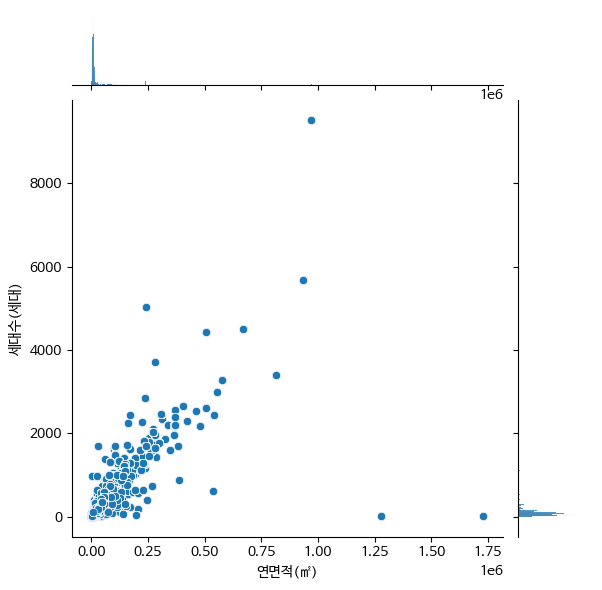

In [804]:
sns.jointplot(data=df_train[df_train['연면적(㎡)'] < 1e7 * 0.8], x='연면적(㎡)', y='세대수(세대)')

In [805]:
train_data = df_train.dropna(subset=['세대수(세대)', '건축면적(㎡)', '전용면적(㎡)', '연면적(㎡)', 'k-건설사(시공사)', '도로명주소'])
X_train = train_data[['세대수(세대)', '전용면적(㎡)', '연면적(㎡)', 'k-건설사(시공사)', '도로명주소']]
y_train = train_data['건축면적(㎡)']

# 트리 모델 학습
aa_model = RandomForestRegressor(random_state=42)
aa_model.fit(X_train, y_train)

# # 결측치가 있는 부분의 연면적 사용하여 주차대수 예측
missing_data = df_train[df_train['건축면적(㎡)'].isnull()]
X_missing = missing_data[['세대수(세대)', '전용면적(㎡)', '연면적(㎡)', 'k-건설사(시공사)', '도로명주소']]
predicted_values = aa_model.predict(X_missing)

# # 결측치 채우기
df_train.loc[df_train['건축면적(㎡)'].isnull(), '건축면적(㎡)'] = predicted_values

## 주차대수 결측치 채우기

In [806]:
train_data = df_train.dropna(subset=['세대수(세대)', '주차대수', '건축면적(㎡)', '전용면적(㎡)', '연면적(㎡)', 'k-건설사(시공사)', '도로명주소'])
X_train = train_data[['세대수(세대)', '건축면적(㎡)', '전용면적(㎡)', '연면적(㎡)', 'k-건설사(시공사)', '도로명주소']]
y_train = train_data['주차대수']

# 트리 모델 학습
pl_model = RandomForestRegressor(random_state=42)
pl_model.fit(X_train, y_train)

# # 결측치가 있는 부분의 연면적 사용하여 주차대수 예측
missing_data = df_train[df_train['주차대수'].isnull()]
X_missing = missing_data[['세대수(세대)', '건축면적(㎡)', '전용면적(㎡)', '연면적(㎡)', 'k-건설사(시공사)', '도로명주소']]
predicted_values = pl_model.predict(X_missing)

# # 결측치 채우기
df_train.loc[df_train['주차대수'].isnull(), '주차대수'] = predicted_values

# 테스트 데이터

In [807]:
# 시군으로 나누기
df_test['시군'] = df_test['시군구'].str.split().str[:2].apply(lambda x: ' '.join(x))

# 도로명 데이터를 이용하여 도로명주소 생성
df_test['주소'] = df_test['시군구'] + ' ' + df_test['번지']
df_test['도로명주소'] = df_test['시군'] + ' ' + df_test['도로명']

# 번지 주소가 없다면 도로명 주소로 채워줌, 번지 주소는 loc을 위함 
df_test.loc[df_test['주소'].isna(), '주소'] = df_test.loc[df_test['주소'].isna(), '시군'] + ' ' + df_test.loc[df_test['주소'].isna(), '도로명']

# 도로명의 값이 ' '인 값들을 찾아서 넣어줌
df_test.loc[(df_test['도로명'] == ' ') & (df_test['주소'] == '서울특별시 성동구 하왕십리동 1071'), '도로명주소'] = '서울특별시 성동구 난계로 100'
df_test.loc[(df_test['도로명'] == ' ') & (df_test['주소'] == '서울특별시 중구 만리동2가 288'), '도로명주소'] = '서울특별시 중구 만리재로 177'
df_test.loc[(df_test['도로명'] == ' ') & (df_test['주소'] == '서울특별시 성북구 돈암동 13-85'), '도로명주소'] = '서울특별시 성북구 돈암동 동소문로34길 73'
df_test.loc[(df_test['도로명'] == ' ') & (df_test['주소'] == '서울특별시 마포구 아현동 372-29'), '도로명주소'] = '서울특별시 마포구 마포대로24길 16'
df_test.loc[(df_test['도로명'] == ' ') & (df_test['주소'] == '서울특별시 송파구 송파동 167'), '도로명주소'] = ' 서울특별시 송파구 오금로32길 31'
df_test.loc[(df_test['도로명'] == ' ') & (df_test['주소'] == '서울특별시 송파구 거여동 696'), '도로명주소'] = '서울특별시 송파구 오금로 551'
df_test.loc[(df_test['도로명'] == ' ') & (df_test['주소'] == '서울특별시 강남구 역삼동 762'), '도로명주소'] = '서울특별시 강남구 도곡로43길 21'
df_test.loc[(df_test['도로명'] == ' ') & (df_test['주소'] == '서울특별시 서초구 반포동 30-2'), '도로명주소'] = '서울특별시 서초구 고무래로 35'
df_test.loc[(df_test['도로명'] == ' ') & (df_test['주소'] == '서울특별시 종로구 옥인동 179-3'), '도로명주소'] = '서울 종로구 옥인길 82'
df_test.loc[(df_test['도로명'] == ' ') & (df_test['주소'] == '서울특별시 강남구 역삼동 763'), '도로명주소'] = '서울 강남구 도곡로43길 20'
df_test.loc[(df_test['도로명'] == ' ') & (df_test['주소'] == '서울특별시 서초구 서초동 1686-4'), '도로명주소'] = '서울 서초구 서초중앙로24길 33'

# 같은 주소이지만 도로명 값이 없는경우 다른 도로명주소가 생겨서 같은 도로명주소로 채워줌 
df_test['도로명주소'] = df_test.groupby('주소')['도로명주소'].transform('first')
df_test['주소'].isna().sum()

0

In [808]:
print('처리전 : ', df_test['k-건설사(시공사)'].isna().sum())
for construction in tqdm(mapping_constructions):
    df_test.loc[df_test['도로명주소'] == construction['도로명주소'], 'k-건설사(시공사)'] = construction['k-건설사(시공사)']
print('처리후 : ', df_test['k-건설사(시공사)'].isna().sum())

처리전 :  6579


100%|██████████| 2362/2362 [00:01<00:00, 1660.00it/s]

처리후 :  1611


In [809]:
df_test['k-건설사(시공사)'] = df_test['k-건설사(시공사)'].fillna('unknown')
df_test['아파트명'] = df_test['아파트명'].fillna('unknown')
for construction in tqdm(constructions):
    df_test.loc[df_test['아파트명'].str.contains(construction), 'k-건설사(시공사)'] = construction

df_test.loc[df_test['k-건설사(시공사)'] == '아크로리버뷰신반포', 'k-건설사(시공사)'] = '대림'

100%|██████████| 97/97 [00:00<00:00, 413.36it/s]


In [810]:
df_test = df_test.merge(df_info, how='left', on=['도로명주소'])
df_test['k-전체세대수'].fillna(df_test['세대수(세대)'], inplace=True)
df_test['건축면적'].fillna(df_test['건축면적(㎡)'], inplace=True)
df_test['k-연면적'].fillna(df_test['연면적(㎡)'], inplace=True)
df_test.drop(columns=['세대수(세대)', '건축면적(㎡)', '연면적(㎡)'], inplace=True)
df_test.rename({"k-전체세대수" : "세대수(세대)", "건축면적" : "건축면적(㎡)", "k-연면적" : "연면적(㎡)"}, axis=1, inplace=True)

In [811]:
df_test = df_test.merge(parkinglot, how='left', on='도로명주소', suffixes=('_1', '_2'))
df_test['주차대수_1'] = df_test['주차대수_1'].fillna(df_test['주차대수_2'])
df_test = df_test.drop(columns=['주차대수_2'], axis=1).rename({'주차대수_1' : '주차대수'}, axis=1)

In [812]:
df_test['건축면적(㎡)'] = df_test['건축면적(㎡)'].apply(lambda x: np.nan if x == 0 else x)
df_test['연면적(㎡)'] = df_test['연면적(㎡)'].apply(lambda x: np.nan if x == 0 else x)
df_test['세대수(세대)'] = df_test['세대수(세대)'].apply(lambda x: np.nan if x == 0 else x)

In [813]:
df_test['계약년월'] = df_test['계약년월'].astype(str)
df_test['계약일'] = df_test['계약일'].astype(str)
df_test['계약일'] = df_test['계약일'].apply(lambda x: '0' + x if len(x) == 1 else x)
df_test['날짜'] = df_test['계약년월'] + df_test['계약일'] 

df_test = df_test.merge(base_interest_rate[['날짜', '기준금리']], how='left', on='날짜')

df_test['기준금리'] = df_test['기준금리'].fillna(1.5)

In [814]:
bus_count_test_df = pd.read_csv('../bus_count_test.csv')
subway_count_test_df = pd.read_csv('../subway_count_test.csv')
school_count_test_df = pd.read_csv('../school_count_test.csv')
hospital_count_test_df = pd.read_csv('../hospital_count_test.csv')
park_count_test_df = pd.read_csv('../park_count_test.csv')

In [815]:
df_test = pd.concat([df_test, bus_count_test_df, subway_count_test_df, school_count_test_df, hospital_count_test_df, park_count_test_df], axis=1) # 테스트 에대한 값도 뽑아야 함

In [816]:
df_test['구'] = df_test['시군구'].str.split().str[1]
df_test['동'] = df_test['시군구'].str.split().str[2]

df_test['한강근처여부'] = df_test['시군구'].apply(lambda x: 1 if x in near_river else 0)
df_test['계약년'] = df_test['계약년월'].astype('str').map(lambda x : x[:4])
df_test['계약월'] = df_test['계약년월'].astype('str').map(lambda x : x[4:])

region_premium = ['서울특별시 강남구', '서울특별시 서초구', '서울특별시 용산구', '서울특별시 송파구']
df_test['지역프리미엄'] = df_test['시군'].apply(lambda x: 1 if x in region_premium else 0)

# 강남의 여부를 체크합니다.
is_gangnam = []
for x in df_test['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
df_test['강남여부'] = is_gangnam

# 신축, 준신축, 구축 구분 
df_test['연식'] = df_test['계약년'].astype(int) - df_test['건축년도']
df_test['건물상태'] = df_test['연식'].apply(buliding_condition)

# 재건축 가능 
df_test['재건축가능'] = 0
df_test.loc[(df_test['연식'] >= 20) & (df_test['건축년도'] <= 1981), '재건축가능'] = 1
df_test.loc[(df_test['연식'] >= 22) & (df_test['건축년도'] <= 1982), '재건축가능'] = 1
df_test.loc[(df_test['연식'] >= 24) & (df_test['건축년도'] <= 1983), '재건축가능'] = 1
df_test.loc[(df_test['연식'] >= 26) & (df_test['건축년도'] <= 1984), '재건축가능'] = 1
df_test.loc[(df_test['연식'] >= 28) & (df_test['건축년도'] <= 1985), '재건축가능'] = 1
df_test.loc[(df_test['연식'] >= 30) & (df_test['건축년도'] <= 1986), '재건축가능'] = 1

df_test['top10'] = 0
# top 10 시공사면 1, 아니면 0
for i, brand in enumerate(top10):
  df_test.loc[df_test['아파트명'].str.contains(brand), 'top10'] = 1


df_test['아파트크기'] = 1
df_test.loc[df_test['전용면적(㎡)'] < 60, '아파트크기'] = 0
df_test.loc[df_test['전용면적(㎡)'] > 85, '아파트크기'] = 2

In [817]:
df_test.drop(drop_columns, axis=1, inplace=True)

In [818]:
for col in tqdm(categorical_columns):
    for idx, label in enumerate(np.unique(df_test[col])):
        lbl_encoder = label_encoders[col]
        if label not in lbl_encoder.classes_: # unseen label 데이터인 경우
            lbl_encoder.classes_ = np.append(lbl_encoder.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!
    df_test[col] = lbl_encoder.transform(df_test[col])

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 11.74it/s]


In [819]:
# # 결측치가 있는 부분의 연면적 사용하여 주차대수 예측
missing_data = df_test[df_test['연면적(㎡)'].isnull()]
X_missing = missing_data[['k-건설사(시공사)', '전용면적(㎡)', '도로명주소']]
predicted_values = tfa_model.predict(X_missing)

# # 결측치 채우기
df_test.loc[df_test['연면적(㎡)'].isnull(), '연면적(㎡)'] = predicted_values

In [820]:
# # 결측치가 있는 부분의 전용면적을 사용하여 건축면적 예측
missing_data = df_test[df_test['세대수(세대)'].isnull()]
X_missing = missing_data[['연면적(㎡)']]
predicted_values = households_model.predict(X_missing)

# # 결측치 채우기
df_test.loc[df_test['세대수(세대)'].isnull(), '세대수(세대)'] = predicted_values

In [821]:
# # 결측치가 있는 부분의 연면적 사용하여 주차대수 예측
missing_data = df_test[df_test['건축면적(㎡)'].isnull()]
X_missing = missing_data[['세대수(세대)', '전용면적(㎡)', '연면적(㎡)', 'k-건설사(시공사)', '도로명주소']]
predicted_values = aa_model.predict(X_missing)

# # 결측치 채우기
df_test.loc[df_test['건축면적(㎡)'].isnull(), '건축면적(㎡)'] = predicted_values

In [822]:
# # 결측치가 있는 부분의 연면적 사용하여 주차대수 예측
missing_data = df_test[df_test['주차대수'].isnull()]
X_missing = missing_data[['세대수(세대)', '건축면적(㎡)', '전용면적(㎡)', '연면적(㎡)', 'k-건설사(시공사)', '도로명주소']]
predicted_values = pl_model.predict(X_missing)

# # 결측치 채우기
df_test.loc[df_test['주차대수'].isnull(), '주차대수'] = predicted_values

In [823]:
df_test['계약월'] = df_test['계약월'].astype('int')
df_test['계약일'] = df_test['계약일'].astype('int') 

In [824]:
assert df_train.drop(columns=['target'], axis=1).shape[1] == df_test.shape[1]

In [825]:
df_train['target'] = np.log1p(df_train['target'])

In [826]:
df_train['type'] = 'train' 
df_test['type'] = 'test'
df_train['index'] = df_train.index
df_test['index'] = df_test.index

concat_df = pd.concat([df_train[['type', 'index', '도로명주소', '층', '동', '날짜', '계약년월', '계약년', '전용면적(㎡)', 'target',]], df_test[['type', 'index', '도로명주소', '동', '층', '날짜', '계약년월', '계약년', '전용면적(㎡)']]])

previous_target_df = concat_df.sort_values(by=['도로명주소', '층', '날짜'])
for i in range(1, 4):
    previous_target_df[f'이전 거래 가격{i}'] = previous_target_df.groupby(['도로명주소', '층'])['target'].shift(i)
    previous_target_df[f'거래 간격{i}'] = previous_target_df['날짜'] - previous_target_df.groupby(['도로명주소', '층'])['날짜'].shift(i)
previous_target_df['전용면적 증감비율'] = previous_target_df.groupby(['도로명주소', '층'])['전용면적(㎡)'].pct_change()

In [827]:
def get_quarter(contract_date):
    month = int(contract_date[-2:])
    quarter = (month - 1) // 3 + 1
    return f"{contract_date[:4]} {quarter}분기"

previous_target_df['분기'] = previous_target_df['계약년월'].apply(get_quarter)

In [828]:
previous_target_df

,type,index,도로명주소,층,동,날짜,계약년월,계약년,전용면적(㎡),target,이전 거래 가격1,거래 간격1,이전 거래 가격2,거래 간격2,이전 거래 가격3,거래 간격3,전용면적 증감비율,분기
1109694,train,1109694,0,1,162,169,200706,0,72.62,10.721084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007 2분기
1109700,train,1109700,0,1,162,182,200707,0,89.14,10.896758,10.721084,13.0,NaN,NaN,NaN,NaN,0.227486,2007 3분기
1109703,train,1109703,0,1,162,191,200707,0,54.35,10.308986,10.896758,9.0,10.721084,22.0,NaN,NaN,-0.390285,2007 3분기
1109671,train,1109671,0,2,162,33,200702,0,54.35,10.454524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007 1분기
1109702,train,1109702,0,2,162,186,200707,0,65.41,10.596660,10.454524,153.0,NaN,NaN,NaN,NaN,0.203496,2007 3분기
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9185,test,9185,8866,2,143,6065,202309,16,68.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023 3분기
9186,test,9186,8866,5,143,6069,202309,16,68.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023 3분기
9183,test,9183,8866,6,143,6049,202308,16,68.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023 3분기
9184,test,9184,8866,14,143,6055,202309,16,68.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023 3분기


In [829]:
daily_price_percentage = previous_target_df.groupby(['날짜', '동'])['target'].mean().reset_index()
daily_price_percentage['전날 동별 평균 가격'] = daily_price_percentage.groupby('동')['target'].shift()
daily_price_percentage['동별 일일 가격 변동률'] = daily_price_percentage.groupby('동')['target'].pct_change()

month_price_percentage = previous_target_df.groupby(['계약년월', '동'])['target'].mean().reset_index()
month_price_percentage['동별 월별 가격 변동률'] = month_price_percentage.groupby('동')['target'].pct_change()

quater_price_percentage = previous_target_df.groupby(['분기', '동'])['target'].mean().reset_index()
quater_price_percentage['동별 분기별 가격 변동률'] = quater_price_percentage.groupby('동')['target'].pct_change()

year_price_percentage = previous_target_df.groupby(['계약년', '동'])['target'].mean().reset_index()
year_price_percentage['동별 연별 가격 변동률'] = quater_price_percentage.groupby('동')['target'].pct_change()

previous_target_df = previous_target_df.merge(daily_price_percentage.drop(columns=['target'], axis=1), how='left', on=['동', '날짜'])
previous_target_df = previous_target_df.merge(month_price_percentage.drop(columns=['target'], axis=1), how='left', on=['동', '계약년월'])
previous_target_df = previous_target_df.merge(quater_price_percentage.drop(columns=['target'], axis=1), how='left', on=['동', '분기'])
previous_target_df = previous_target_df.merge(year_price_percentage.drop(columns=['target'], axis=1), how='left', on=['동', '계약년'])

In [830]:
train_previous_target_df = previous_target_df[previous_target_df['type'] == 'train'].sort_values(by='index').reset_index().drop(columns=['index', 'level_0'], axis=1)
test_previous_target_df = previous_target_df[previous_target_df['type'] == 'test'].sort_values(by='index').reset_index().drop(columns=['index', 'level_0'], axis=1)

In [832]:
df_train = pd.concat([df_train, train_previous_target_df[['이전 거래 가격1', '이전 거래 가격2', '이전 거래 가격3', '거래 간격1', '거래 간격2', '거래 간격3', '전용면적 증감비율', '전날 동별 평균 가격', '동별 일일 가격 변동률', '동별 월별 가격 변동률', '동별 분기별 가격 변동률', '동별 연별 가격 변동률']]], axis=1)
df_test = pd.concat([df_test, test_previous_target_df[['이전 거래 가격1', '이전 거래 가격2', '이전 거래 가격3', '거래 간격1', '거래 간격2', '거래 간격3', '전용면적 증감비율', '전날 동별 평균 가격', '동별 일일 가격 변동률', '동별 월별 가격 변동률', '동별 분기별 가격 변동률', '동별 연별 가격 변동률']]], axis=1)

In [833]:
df_train.drop(columns=['type', 'index'], axis=1, inplace=True)
df_test.drop(columns=['type', 'index'], axis=1, inplace=True)

In [834]:
df_train['이전 거래 변동률'] = (df_train['이전 거래 가격1'] - df_train['이전 거래 가격2']) / df_train['이전 거래 가격2']
df_test['이전 거래 변동률'] = (df_test['이전 거래 가격1'] - df_test['이전 거래 가격2']) / df_test['이전 거래 가격2']

In [835]:
df_train['target_mean'] = df_train[['이전 거래 가격1', '이전 거래 가격2', '이전 거래 가격3']].mean(axis=1)
df_train['target_std'] = df_train[['이전 거래 가격1', '이전 거래 가격2', '이전 거래 가격3']].std(axis=1)
df_train['target_var'] = df_train[['이전 거래 가격1', '이전 거래 가격2', '이전 거래 가격3']].var(axis=1)

df_test['target_mean'] = df_test[['이전 거래 가격1', '이전 거래 가격2', '이전 거래 가격3']].mean(axis=1)
df_test['target_std'] = df_test[['이전 거래 가격1', '이전 거래 가격2', '이전 거래 가격3']].std(axis=1)
df_test['target_var'] = df_test[['이전 거래 가격1', '이전 거래 가격2', '이전 거래 가격3']].var(axis=1)

In [836]:
df_train['전용/건축면적'] = df_train['전용면적(㎡)'] / df_train['건축면적(㎡)'] 
df_test['전용/건축면적'] = df_test['전용면적(㎡)'] / df_test['건축면적(㎡)'] 

In [837]:
df_train['신규'] = df_train['이전 거래 가격1'].isna().apply(lambda x: 1 if x else 0)
df_train['분양'] = 0
df_train.loc[(df_train['신규'] == 1) & (df_train['연식'] == 0), '분양'] = 1

df_test['신규'] = df_test['이전 거래 가격1'].isna().apply(lambda x: 1 if x else 0)
df_test['분양'] = 0
df_test.loc[(df_train['신규'] == 1) & (df_train['연식'] == 0), '분양'] = 1

In [838]:
def get_quarter(contract_date):
    month = int(contract_date[-2:])
    quarter = (month - 1) // 3 + 1
    return quarter

df_train['분기'] = df_train['계약년월'].apply(get_quarter)
df_test['분기'] = df_test['계약년월'].apply(get_quarter)

In [839]:
df_train.drop(columns=['계약년월'], axis=1, inplace=True)
df_test.drop(columns=['계약년월'], axis=1, inplace=True)

In [841]:
df_train.to_csv('../train_df1.csv', index=False)
df_test.to_csv('../test_df1.csv', index=False)